In [39]:
import numpy as np

from scipy.stats import trapz
from scipy.stats import norm
from scipy.stats import uniform

# for widget interactive stuff
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib notebook

# Parameter Identification / Estimator
Here's my attempt to work through Michael and Troy's parameter estimation methodology.

Suppose we have a bunch of observations of some model $Y(\lambda)$, where $\lambda$ has some true specific value, $\lambda_0$, that we want to estimate. Suppose that our model is:

\begin{align}
Y(\lambda)&=\lambda^2
\end{align}

Now suppose that our observations of the model $Y(\lambda)$ are polluted by noise. That is, we observe some data values $d_i$, where each $d_i$ is:

\begin{align}
d_i&=Y(\lambda)+\epsilon_i \\
&=\lambda_0^2+\epsilon_i
\end{align}

Whereas we do not know the true value of $\lambda$, suppose we know that the noise is normally distributed with mean 0 (error is unbiased) and known variance $\sigma^2$.


First lets simulate just this much of the process.

In [40]:
# we have some true value of lambda:
lam_true = 1.23

In [41]:
# we have the model Y:
def model_Y(x):
    return x**2

In [42]:
# we have some noise
noise = 0.5 # how noisy?
epsilon = norm(0,noise) # mean 0

In [43]:
# and some observations of the model Y with noise
N = 2500 # number of observations
obs_data = model_Y(lam_true)+epsilon.rvs(N)

The first part of our approach is to define some variation of $\lambda$ based on our prior knowledge. Suppose we know that $\lambda_0$ must be between 0 and 2, but we have no idea of where in this range the true value is. Thus we suppose that $\lambda_0\sim U[0,2]$.

In [44]:
# this is the prior
lam_prior = uniform(0,2)

Now we want to form a quantity that we can compute the push-forward of. However, we cannot use compute the data $Y(\lambda)+\epsilon_i$ because we do not know the true value of $\lambda_0$. We also do not know the true distribution of $\epsilon_i$.

What do we do?

We form a new quantity: the residuals for our given data. That is we calculate:

\begin{align}
q = Q(\lambda\mid d_i) = \sum_{i=1}^N \left(d_i-Y(\lambda)\right)
\end{align}

Note that this simplifies to be:
\begin{align}
Q(\lambda\mid d_i) &= \sum_{i=1}^N \left(d_i-Y(\lambda)\right) \\
&= \sum_{i=1}^N \left(Y(\lambda)+\epsilon_i-Y(\lambda)\right) \\
&= \sum_{i=1}^N \epsilon_i
\end{align}

Now we know that the $q$ will have distribution $N(0,n\sigma^2)$, since the sum of normals is normal. We know the sample size $n$ and the variance $\sigma^2$, so we know what the observed distribution of $q$ should be given the data $d_i$.

To update our initial guess of the variation of $\lambda_0$, we re-weight the distribution using the ratio of this expected $q$ distribution given the data and an estimation of this distribution given our initial guess of $\lambda$.

In other words, we use the consistent inversion ratio:

\begin{align}
\pi^{up}(\lambda)&=\pi^{init}(\lambda)\cdot\dfrac{\pi^{obs}\left(Q(\lambda)\right)}{\pi^{pf}\left(Q(\lambda)\right)}
\end{align}

where the push-forward is computed by fixing $d_i$ and assuming $\lambda$ is a random variable, whereas the observed is found analytically by the discussion above. Let's try and put these pieces together.

In [45]:
def Q(lam, data):
    q = np.sum(data)-len(data)*model_Y(lam)  # constant - vector of potential lambdas
    return q

In [46]:
# the observed distribution of the residuals from Q
q_obs = norm(0,np.sqrt(N)*noise) # variance n*sigma^2

In [47]:
# generate sample of lambda
n = 1000
lam_prior_sample = lam_prior.rvs(n)

In [48]:
# compute push-forward of lambda using the map
q_push_forward = Q(lam_prior_sample,obs_data)

<IPython.core.display.Javascript object>


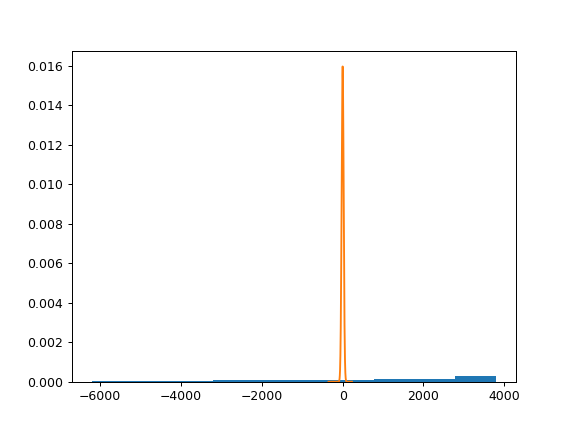

In [49]:
plt.figure()
plt.hist(q_push_forward,density=True)
plt.plot(np.linspace(-350,230,200),q_obs.pdf(np.linspace(-350,230,200)))

Because our model map $Y$ is simple, in this case I think we can compute the exact push-forward of the variable $\lambda$ through the model map $Q(\lambda)$.

First let's simply the map $Q$ in the following way:
\begin{align}
Q(\lambda\mid d_i)&=-N\cdot Y(\lambda)+\sum_{i=1}^Nd_i
\end{align}

Now we know that the distribution of $Y$ is:
\begin{align}
Y\sim f_y(y)&=\begin{cases} \frac{1}{4}y^{-1/2}, & y\in[0,4] \\
0, & \text{otherwise}\end{cases}
\end{align}

which can be computed using basic transformations of random variables. Therefore, the modified random variable will be scaled by $-N$ and increased by the constant sum of data values $\sum_{i}^N d_i$. Together this will give the pdf:

\begin{align}
Q^{pf}\sim \pi_q^{pf}(q)&= \begin{cases} \frac{1}{4N}\left(\, \dfrac{s-q}{N}\, \right)^{-1/2}, & q\in[s-4N,s] \\
0, & \text{otherwise}\end{cases}
\end{align}

where $s=\sum_id_i$.

In [50]:
# explicitly define exact pdf
s = np.sum(obs_data)

def push_forward_pdf(q):
    if q.shape != 1:
        out = np.zeros(q.shape)
        which_positive = np.logical_and(s-4*N<=q,q<=s)
        
        out[which_positive] = 1/(4*np.sqrt(N)*np.sqrt(s-q[which_positive]))
        
    else:
        which_positive = 'none'
    return out
        

In [51]:
# compute the updated sample
# calculate maximum of the ratio
M = np.max(q_obs.pdf(q_push_forward)/push_forward_pdf(q_push_forward))

# generate random numbers from uniform for accept-reject for each sample value
test_value = np.random.uniform(0,1,np.shape(q_push_forward))

# calculate the ratio for accept reject: data_kde/push_kde/M and compare to test sample
# is the kde ratio > test value?
accept_or_reject_samples = np.greater(q_obs.pdf(q_push_forward)/push_forward_pdf(q_push_forward)/M,
                            test_value)

# accepted values of posterior sample
lam_update_sample = lam_prior_sample[accept_or_reject_samples]

<IPython.core.display.Javascript object>


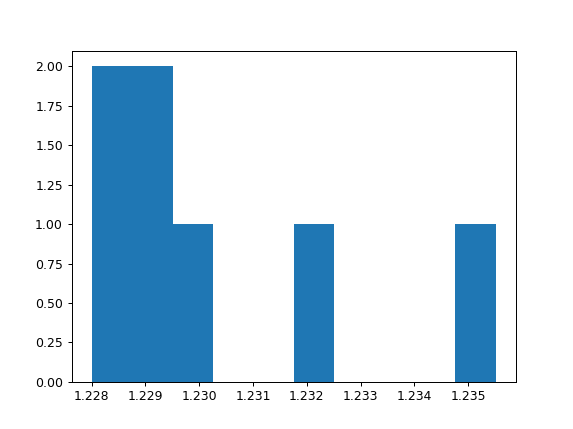

1.23030362753
1.22921480655


In [52]:
plt.figure()
plt.hist(lam_update_sample)
print(np.mean(lam_update_sample))
print(np.median(lam_update_sample))

## Find maximum lambda value as the point estimate analytically.

We know the pdf for this example case and can write it explicitly.

\begin{align}
\pi^{up} = \pi^{init}\cdot\dfrac{\pi^{obs}}{\pi^{pf}}
\end{align}

We want to find the maximizing relative probability value $\lambda^*$. We can get this by taking the derivative of the updated pdf $\pi^{up}$ with respect to lambda. In other words, we want:

\begin{align}
\arg\max_\lambda\left(\pi^{up}\right)\Leftrightarrow \arg\max_\lambda\left(\log(\pi^{up})\right)
\end{align}

Which means that $\lambda^*$ should satisfy:

\begin{align}
0&=\dfrac{\partial}{\partial\lambda}\left(\log(\pi^{init}(\lambda))+\log(\pi^{obs}(Q(\lambda)))-\log(\pi^{pf}(Q(\lambda))\right)\\
&=\dfrac{1}{\pi^{init}(\lambda)}\cdot \frac{d}{d\lambda}\pi^{init} (\lambda) +\dfrac{1}{\pi^{obs}(Q(\lambda))}\cdot\dfrac{d\pi^{obs}}{dq}\cdot Q'(\lambda)-\dfrac{1}{\pi^{pf}(Q(\lambda))}\cdot\dfrac{d\pi^{pf}}{dq}\cdot Q'(\lambda)\\
\end{align}

In our specific example, we can write this out explicitly as:
\begin{align}
0&=\dfrac{1}{\frac{1}{2}I_{[0,2]}}\cdot 0 + \left(\dfrac{1}{\sqrt{2\pi N\sigma^2}}e^{-\frac{Q(\lambda)^2}{2 N\sigma^2}}\right)^{-1}\cdot \left(\dfrac{1}{\sqrt{2\pi N\sigma^2}}e^{-\frac{Q(\lambda)^2}{2 N\sigma^2}}\cdot -\frac{2Q(\lambda)}{2N\sigma^2}\right)\cdot Q'(\lambda) \\
&\quad\quad- \left(\frac{1}{4N}\left(\, \dfrac{s-q}{N}\, \right)^{-1/2}\right)^{-1}\cdot \left(\frac{1}{4N}\cdot\frac{-1}{2}\cdot\left(\, \dfrac{s-q}{N}\, \right)^{-1/2-1}\cdot-\frac{1}{N}\right)\cdot Q'(\lambda) \\[2ex]
&=-\frac{Q(\lambda)}{N\sigma^2}\cdot Q'(\lambda)-\frac{1}{2N}\left(\, \dfrac{s-Q(\lambda)}{N}\, \right)^{-1}Q'(\lambda) \\[2ex]
&=-\frac{Q(\lambda)}{N\sigma^2}-\frac{1}{2N}\left(\, \dfrac{s-Q(\lambda)}{N}\, \right)^{-1}
\end{align}

Now using the definition of $Q(\lambda)$, we will have:

\begin{align}
-\frac{1}{N\sigma^2}\cdot\left(-N\cdot Y(\lambda)+s\right)-\frac{1}{2}\left(\, \dfrac{1}{s-(-N\cdot Y(\lambda)+s)}\, \right)&=0 \\[2ex]
\frac{1}{\sigma^2}\left(\, Y(\lambda)-\frac{s}{N}\,\right)-\left(\, \dfrac{1}{2N\cdot Y(\lambda))}\, \right)&=0 \\[2ex]
\frac{1}{\sigma^2}\left(\, Y(\lambda)-\frac{s}{N}\,\right)&=\left(\, \dfrac{1}{2N\cdot Y(\lambda))}\, \right) \\[2ex]
Y(\lambda)\left(\, Y(\lambda)-\frac{s}{N}\,\right)&=\left(\, \dfrac{\sigma^2}{2N}\, \right) \\[2ex]
Y(\lambda)^2 -\frac{s}{N}Y(\lambda)-\dfrac{\sigma^2}{2N}&=0 \\[2ex]
\end{align}

Using the quadratic formula we will have:

\begin{align}
Y(\lambda)&=\dfrac{\frac{s}{N}\pm\sqrt{\frac{s^2}{N^2}+2\frac{\sigma^2}{N}}}{2} \\[2ex]
\Rightarrow\quad \hat{\lambda}&=\sqrt{\dfrac{s+\sqrt{s^2+2N\sigma^2}}{2N}}
\end{align}

Because the discriminant $\sqrt{s^2+2N\sigma^2}\geq s$, so only the positive root can be obtained, and values of $\lambda$ are bounded between $[0,2]$.

In [53]:
# lambda estimate squared, numerical value
np.sqrt((s+np.sqrt(s**2+2*N*noise**2))/2/N)

1.2303696859947264

Note that the analytical computation of the maximum point is consistent with the numerical results computed using sampling.

Now that we have a closed form for $\hat{\lambda}$, we can easily check the bias of the estimator, using Taylor's Theorem. Taylor's theorem says that:

\begin{align}
(1+K)^{1/2}&=1+\frac{1}{2}K-\frac{1}{4\cdot 2!}K^2+\frac{3}{8\cdot 3!}K^3-\frac{15}{16\cdot4!}c^{-7/2}(K)^4
\end{align}

So we can expand our estimator of $\lambda$ in the following manner:
\begin{align}
E(\hat{\lambda})&=\frac{1}{\sqrt{2N}}E\left(\left(s+\sqrt{s^2+2N\sigma^2}\right)^{1/2}\right)\\[2ex]
&=\frac{1}{\sqrt{2N}}E\left(\left(s+s\sqrt{1+\frac{2N\sigma^2}{s^2}}\right)^{1/2}\right)\\[2ex]
&=\frac{1}{\sqrt{2N}}E\left(\left(s+s\left(1+\frac{1}{2}\left(\frac{2N\sigma^2}{s^2}\right)-\frac{1}{4\cdot2!}\left(\frac{2N\sigma^2}{s^2}\right)^2+\ldots\right)\right)^{1/2}\right)\\[2ex]
&=\frac{1}{\sqrt{2N}}E\left(\left(2s+\frac{N\sigma^2}{s}-\frac{(2N\sigma^2)^2}{4\cdot2!\cdot s^3}+\ldots\right)^{1/2}\right)\\[2ex]
&=\frac{1}{\sqrt{2N}}E\left(\sqrt{2s}\cdot\left(1+\frac{N\sigma^2}{2s^2}-\frac{(2N\sigma^2)^2}{8s^4}+\ldots\right)^{1/2}\right)\\[2ex]
&=\frac{1}{\sqrt{2N}}E\left(\sqrt{2s}\cdot\left(1+K\right)^{1/2}\right)\\[2ex]
&=\frac{1}{\sqrt{2N}}E\left(\sqrt{2s}\cdot\left(1+\frac{1}{2}K-\frac{K^2}{4\cdot 2!}+\ldots \right)\right)\\[2ex]
&=\frac{1}{\sqrt{2N}}E\left(\sqrt{2s}+\frac{1}{2}K\sqrt{2s}-\frac{K^2}{4\cdot 2!}\sqrt{2s}+\ldots \right)\\[2ex]
&=\frac{1}{\sqrt{2N}}\left(E\left(\sqrt{2s}\right)+\frac{1}{2}E\left(K\sqrt{2s}\right)-E\left(\frac{K^2}{4\cdot 2!}\sqrt{2s}\right)+\ldots \right)\\[2ex]
\end{align}

\begin{align}
E\left(\hat{\lambda}\right)&=E\left(\sqrt{\dfrac{\sum_{i}d_i}{N}}\right)+\frac{1}{2\sqrt{N}}E\left(\dfrac{N\sigma^2}{\sqrt{\sum_id_i}}-\dfrac{1}{4\cdot2!}\left(\dfrac{4N^2\sigma^4}{s^{3/2}}\right)\right)
\end{align}

In general, for a $N(0,1)$ observed quantity of interest, we will have the following type situation:

\begin{align}
0&=\dfrac{\partial}{\partial\lambda}\left(\log(\pi^{init}(\lambda))+\log(\pi^{obs}(Q(\lambda)))-\log(\pi^{pf}(Q(\lambda))\right)\\
&=\dfrac{1}{\pi^{init}(\lambda)}\cdot \frac{d}{d\lambda}\pi^{init} (\lambda) - Q(\lambda)\cdot Q'(\lambda)-\dfrac{1}{\pi^{pf}(Q(\lambda))}\cdot\dfrac{d\pi^{pf}}{dq}\cdot Q'(\lambda)\\
\end{align}

We can simplify our analysis by using the fact that $Q$ defines a linear transformation of the random variable $Y(\lambda)$. Specifically, we know that:

\begin{align}
Q(\lambda)&=\frac{1}{\sigma\sqrt{N}}\sum_i{d_i}-\frac{N}{\sigma\sqrt{N}}Y(\lambda)=a-bY(\lambda) \\[2ex]
\pi^{pf}_Q(q)&=\dfrac{1}{b}\pi^{pf}_Y\left(\dfrac{a-q}{b}\right)
\end{align}

where $a=\frac{1}{\sigma\sqrt{N}}\sum_id_i$ and $b=\frac{N}{\sigma\sqrt{N}}$

we should get the following:

\begin{align}
\dfrac{1}{\pi^{init}(\lambda)}\cdot \frac{d\pi^{init}}{d\lambda} - \left(a-bY(\lambda)\right)\cdot (-bY'(\lambda))-\dfrac{1}{\frac{1}{b}\pi^{pf}_Y\left(\frac{a-Q(\lambda)}{b}\right)}\cdot\dfrac{d}{dq}\left(\frac{1}{b}\pi^{pf}_Y\left(\frac{a-Q(\lambda)}{b}\right)\right)\cdot (-bY'(\lambda))&=0\\[2ex]
\dfrac{1}{\pi^{init}(\lambda)}\cdot \frac{d\pi^{init}}{d\lambda} - \left(a-bY(\lambda)\right)\cdot (-bY'(\lambda))-\dfrac{1}{\pi^{pf}_Y\left(\frac{a-Q(\lambda)}{b}\right)}\cdot\left(\dfrac{d\pi^{pf}_Y}{dy}\left(\frac{-1}{b}\right)\right)\cdot (-bY'(\lambda))&=0\\[2ex]
\dfrac{\partial_\lambda\pi^{init}}{\pi^{init}} + \left(ab-b^2Y\right)\partial_\lambda Y-\left(\dfrac{\partial_y\pi^{pf}_Y}{\pi^{pf}_Y}\right)\partial_\lambda Y&=0\\[2ex]
\end{align}

Let's clean up the constants in this expression a little bit. We know that $b=\frac{\sqrt{N}}{\sigma}$, so we can simplify as follows:

\begin{align}
\dfrac{\partial_\lambda\pi^{init}}{\pi^{init}} + \left(\dfrac{\sum_id_i}{\sigma^2}-\dfrac{N}{\sigma^2}Y\right)\partial_\lambda Y-\left(\dfrac{\partial_y\pi^{pf}_Y}{\pi^{pf}_Y}\right)\partial_\lambda Y&=0\\[2ex]
\end{align}

This should hold true for any maps that have the appropriate derivatives, using an assumption of normal errors in your measurement of $Y$.

#### Sanity Check:
Just check that this is consistent with derived estimate in case where prior is uniform 0 to 2 and $Y(\lambda)=\lambda^2$.
\begin{align}
0 + \left(\dfrac{\sum_id_i}{\sigma^2}-\dfrac{N}{\sigma^2}\lambda^2\right)\cdot 2\lambda -\left(\dfrac{\frac{-1}{8}y^{-3/2}}{\frac{1}{4}y^{-1/2}}\right)\cdot 2\lambda&=0\\[2ex]
%
\left(\dfrac{\sum_id_i}{\sigma^2}-\dfrac{N}{\sigma^2}\lambda^2\right) +\left(\dfrac{1}{2y}\right)&=0\\[2ex]
%
\left(\dfrac{\sum_id_i}{\sigma^2}-\dfrac{N}{\sigma^2}\lambda^2\right) +\left(\dfrac{1}{2\lambda^2}\right)&=0\\[2ex]
%
\dfrac{N}{\sigma^2}\lambda^4-\left(\dfrac{\sum_id_i}{\sigma^2}\right)\lambda^2 -\frac{1}{2}&=0\\[2ex]
\end{align}



#### Continue the Derivation
Now define $f_\lambda(\lambda)=\dfrac{\partial_\lambda\pi^{init}}{\pi^{init}}$ and $g_y(y)=\dfrac{\partial_y\pi^{pf}_Y}{\pi^{pf}_Y}$.

We know that $\hat{\lambda}$ should satisfy the above differential equation. So, next, we attempt to use the Taylor series expansion around the true value of $\lambda$, call it $\lambda_0$, to get bounds on the bias of our max density estimator.

\begin{align}
Y(\hat{\lambda})&=Y(\lambda_0)+Y'(\lambda_0)(\hat{\lambda}-\lambda_0)+\frac{1}{2}Y''(\lambda_0)(\hat{\lambda}-\lambda_0)^2+\ldots
\end{align}

Next, we try and use this expansion to get an estimate of the bias:

\begin{align}
f_\lambda(\hat{\lambda})+\left(\dfrac{\sum_id_i}{\sigma^2}-\dfrac{N}{\sigma^2}Y(\hat{\lambda})\right)\partial_\lambda Y(\hat{\lambda})-g_y\left(Y(\hat{\lambda})\right)\partial_\lambda Y(\hat{\lambda})&=0 \\[2ex]
%
f_\lambda(\hat{\lambda})+\left(\dfrac{NY(\lambda_0)+\sum_i\epsilon_i}{\sigma^2}-\dfrac{N}{\sigma^2}Y(\hat{\lambda})\right)\partial_\lambda Y(\hat{\lambda})-g_y\left(Y(\hat{\lambda})\right)\partial_\lambda Y(\hat{\lambda})&=0 \\[2ex]
%
f_\lambda(\hat{\lambda})+\left(\dfrac{NY(\lambda_0)+\sum_i\epsilon_i}{\sigma^2}-\dfrac{N}{\sigma^2}\left(Y(\lambda_0)+Y'(\lambda_0)(\hat{\lambda}-\lambda_0)+\frac{1}{2}Y''(\lambda_0)(\hat{\lambda}-\lambda_0)^2+\ldots\right)\right)\partial_\lambda Y(\hat{\lambda})-g_y\left(Y(\hat{\lambda})\right)\partial_\lambda Y(\hat{\lambda})&=0 \\[2ex]
%
f_\lambda(\hat{\lambda})+\left(\dfrac{1}{\sigma^2}\sum_i\epsilon_i-\dfrac{N}{\sigma^2}\left(Y'(\lambda_0)(\hat{\lambda}-\lambda_0)+\frac{1}{2}Y''(\lambda_0)(\hat{\lambda}-\lambda_0)^2+\ldots\right)\right)\partial_\lambda Y(\hat{\lambda})-g_y\left(Y(\hat{\lambda})\right)\partial_\lambda Y(\hat{\lambda})&=0 \\[2ex]
\end{align}


### Middle Term

This is going to get unwieldly. Let's just focus on the middle term for now:
\begin{align}
&\ \left(\dfrac{1}{\sigma^2}\sum_i\epsilon_i-\dfrac{N}{\sigma^2}\left(Y'(\lambda_0)(\hat{\lambda}-\lambda_0)+\frac{1}{2}Y''(\lambda_0)(\hat{\lambda}-\lambda_0)^2+\ldots\right)\right)\partial_\lambda Y(\hat{\lambda}) \\[2ex]
&=\left(\dfrac{1}{\sigma^2}\sum_i\epsilon_i-\dfrac{N}{\sigma^2}\left(Y'(\lambda_0)(\hat{\lambda}-\lambda_0)+\frac{1}{2}Y''(\lambda_0)(\hat{\lambda}-\lambda_0)^2+\ldots\right)\right)\left(Y'(\lambda_0)+Y''(\lambda_0)(\hat{\lambda}-\lambda_0)+\dfrac{1}{2}Y'''(\lambda_0)(\hat{\lambda}-\lambda_0)^2+\ldots\right)
\end{align}



Multiply all terms and gather all the factors $(\hat{\lambda}-\lambda_0)^p$ together:

\begin{align}
\text{0th degree:}&\quad \dfrac{Y'(\lambda_0)}{\sigma^2}\sum_i\epsilon_i \\
\text{1st degree:}&\quad \left(\dfrac{Y''(\lambda_0)}{\sigma^2}\sum_i\epsilon_i-\dfrac{NY'(\lambda_0)^2}{\sigma^2}\right)(\hat{\lambda}-\lambda_0) \\
\text{2nd degree:}&\quad \left(\dfrac{Y'''(\lambda_0)}{2\sigma^2}\sum_i\epsilon_i-\dfrac{NY'(\lambda_0)Y''(\lambda_0)}{\sigma^2}-\dfrac{NY''(\lambda_0)Y'(\lambda_0)}{2\sigma^2}\right)(\hat{\lambda}-\lambda_0)^2=\left(\dfrac{Y'''(\lambda_0)}{2\sigma^2}\sum_i\epsilon_i-\dfrac{3NY'(\lambda_0)Y''(\lambda_0)}{2\sigma^2}\right)(\hat{\lambda}-\lambda_0)^2 \\
\vdots\quad &\quad +\text{higher order terms}
\end{align}


### Last Term
In order to get an estimate for the last term, we need to use Taylor's theorem using the chainrule for composite functions. We should get something like this:

$$g(h(x))=g(h(a))+(x-a)g'(h(a))h'(a)+\dfrac{1}{2}(x-a)^2\left(g''(h(a))h'(a)^2+h''(a)g'(h(a))\right)+\ldots$$


This means, for the last term, we will have:

\begin{align}
g_y\left(Y(\hat{\lambda})\right)\partial_\lambda Y(\hat{\lambda})&=
%
\left(g_y(Y(\lambda_0))+(\hat{\lambda}-\lambda_0)\left(g'_y(Y(\lambda_0)Y'(\lambda_0)\right)+\frac{1}{2}(\hat{\lambda}-\lambda_0)^2\left(g_y''(Y(\lambda_0)Y'(\lambda_0)^2+Y''(\lambda_0)g_y'(Y(\lambda_0))\right)+\ldots\right) \\
&\quad\quad \times\left(Y'(\lambda_0)+Y''(\lambda_0)(\hat{\lambda}-\lambda_0)+\dfrac{1}{2}Y'''(\lambda_0)(\hat{\lambda}-\lambda_0)^2+\ldots\right)\\[2ex]
%
\end{align}

Multiply all terms and gather all the factors $(\hat{\lambda}-\lambda_0)^p$ together:

\begin{align}
\text{0th degree:}&\quad g_y(Y(\lambda_0))Y'(\lambda_0) \\
%
\text{1st degree:}&\quad (\hat{\lambda}-\lambda_0)\left[g'_y(Y(\lambda_0))Y'(\lambda_0)^2+g_y(Y(\lambda_0))Y''(\lambda_0)\right] \\
%
\text{2nd degree:}&\quad (\hat{\lambda}-\lambda_0)^2 
\left[ \frac{1}{2}\left(g_y''(Y(\lambda_0)Y'(\lambda_0)^2+
Y''(\lambda_0)g_y'(Y(\lambda_0))\right)Y'(\lambda_0)+ g'_y(Y(\lambda_0)Y'(\lambda_0)Y''(\lambda_0)+\frac{1}{2}g_y(Y(\lambda_0))Y'''(\lambda_0)\right] \\
\vdots\quad &\quad +\text{higher order terms}
\end{align}


### First Term
First term is easy to expand using Taylor series. We get:

\begin{align}
f_\lambda(\hat{\lambda})&=f_\lambda(\lambda_0)+f_\lambda'(\lambda_0)(\hat{\lambda}-\lambda_0)+\frac{1}{2}f_\lambda''(\lambda_0)(\hat{\lambda}-\lambda_0)^2+\ldots
\end{align}

### All Terms Grouped Together by Powers
Now we group all the terms together by powers, just to have a sense of what they look like:

#### 0th Order Terms:
\begin{align}
f_\lambda(\lambda_0)+\dfrac{Y'(\lambda_0)}{\sigma^2}\sum_i\epsilon_i - g_y(Y(\lambda_0))Y'(\lambda_0)\\
\end{align}

#### 1st Order Terms:
\begin{align}
(\hat{\lambda}-\lambda_0)\left[f_\lambda'(\lambda_0)+\left(\dfrac{Y''(\lambda_0)}{\sigma^2}\sum_i\epsilon_i-\dfrac{NY'(\lambda_0)^2}{\sigma^2}\right)- \left(g'_y(Y(\lambda_0))Y'(\lambda_0)^2+g_y(Y(\lambda_0))Y''(\lambda_0)\right)\right]
\end{align}

#### 2nd Order Terms:
\begin{align}
(\hat{\lambda}-\lambda_0)^2&\left[\frac{1}{2}f_\lambda''(\lambda_0)+
%
\left(\dfrac{Y'''(\lambda_0)}{2\sigma^2}\sum_i\epsilon_i-\dfrac{3NY'(\lambda_0)Y''(\lambda_0)}{2\sigma^2}\right)\right.\\
%
&\quad\quad \left.-\left(\frac{1}{2}\left(g_y''(Y(\lambda_0)Y'(\lambda_0)^2+
Y''(\lambda_0)g_y'(Y(\lambda_0))\right)Y'(\lambda_0)+ g'_y(Y(\lambda_0)Y'(\lambda_0)Y''(\lambda_0)+\frac{1}{2}g_y(Y(\lambda_0))Y'''(\lambda_0)\right)
\right]
\end{align}


Now, lets try and simplify our lives by rewriting in terms of a bunch of constants.

Constants which come from the observed quantity (**middle term**):

\begin{align}
a_0&=\frac{Y'(\lambda_0)}{\sigma^2} \\
a_1&=\frac{Y''(\lambda_0)}{\sigma^2} & \quad b_1&=\frac{Y'(\lambda_0)^2}{\sigma^2} \\
a_2&=\frac{Y'''(\lambda_0)}{2\sigma^2}& \quad b_2&=\frac{3Y'(\lambda_0)Y''(\lambda_0)}{2\sigma^2}
\end{align}


Constants which come from the push-forward quantity (**last term**):

\begin{align}
g_0&=g_y(Y(\lambda_0))Y'(\lambda_0) \\
g_1&=g_y'(Y(\lambda_0))Y'(\lambda_0)^2+g_y(Y(\lambda_0))Y''(\lambda_0)\\
g_2&=\frac{1}{2}\left(g_y''(Y(\lambda_0)Y'(\lambda_0)^2+
Y''(\lambda_0)g_y'(Y(\lambda_0))\right)Y'(\lambda_0)+ g'_y(Y(\lambda_0)Y'(\lambda_0)Y''(\lambda_0)+\frac{1}{2}g_y(Y(\lambda_0))Y'''(\lambda_0)
\end{align}


So our differential equation will look something like this:

\begin{align}
\left(f_\lambda+a_0\sum_i\epsilon_i-g_0\right)+(\hat{\lambda}-\lambda_0)\left(f_\lambda'+a_1\sum_i\epsilon_i -N b_1- g_1\right)+(\hat{\lambda}-\lambda_0)^2\left(\frac{1}{2}f_\lambda''+a_2\sum_i\epsilon_i -N b_2- g_2\right)&=0
\end{align}

Moving terms to the other side of the equation, we will have:
\begin{align}
(\hat{\lambda}-\lambda_0)\left(f_\lambda'+a_1\sum_i\epsilon_i -N b_1- g_1\right)&=-\left(f_\lambda+a_0\sum_i\epsilon_i-g_0\right)-(\hat{\lambda}-\lambda_0)^2\left(\frac{1}{2}f_\lambda''+a_2\sum_i\epsilon_i -N b_2- g_2\right)
\end{align}

#### Sanity Check:
Check this result using initial distribution $U[0,2]$ and $Y(\lambda)=\lambda^2$. Since $f_\lambda$ is a ratio of the derivative of the initial distribution to the distribution, these terms will be zero because our initial was uniform. Further, all the derivative terms of $Y$ higher than order 3 will drop out to zero.

\begin{align}
    (\hat{\lambda}-\lambda_0)\left(\frac{2}{\sigma^2}\sum_i\epsilon_i -N \frac{4\lambda_0^2}{\sigma^2}- g_1\right)&=-\left(0+\frac{2}{\sigma^2}\sum_i\epsilon_i-g_0\right)-(\hat{\lambda}-\lambda_0)^2\left(0+0 -N \frac{6}{\sigma^2}- g_2\right)
\end{align}



#### Expectation of LHS:
We focus on investigating the left-hand side of the equation. First, we separate the terms into the stochastic components and the constant components. We will have:

\begin{align}
(\hat{\lambda}-\lambda_0)\left(f_\lambda'+a_1\sum_i\epsilon_i -N b_1- g_1\right)&=(\hat{\lambda}-\lambda_0)\left(f_\lambda' -N b_1- g_1\right)+(\hat{\lambda}-\lambda_0)a_1\sum_i\epsilon_i \\[2ex]
%
&=N(\hat{\lambda}-\lambda_0)\left(\frac{f_\lambda'}{N} - b_1- \frac{1}{N}g_1\right)+a_1(\hat{\lambda}-\lambda_0)\sum_i\epsilon_i \\[2ex]
\end{align}

Next we take the expected value of this side of the equation (we will take the expected value of the other side of the equation later:

\begin{align}
&=E\left[N(\hat{\lambda}-\lambda_0)\left(\frac{f_\lambda'}{N} - b_1- \frac{\sigma}{N\sqrt{N}}g_1\right)+a_1(\hat{\lambda}-\lambda_0)\sum_i\epsilon_i\right] \\[2ex]
%
&=NE\left[(\hat{\lambda}-\lambda_0)\right]\left(\frac{f_\lambda'}{N} - b_1- \frac{1}{N}g_1\right)+a_1E\left[(\hat{\lambda}-\lambda_0)\sum_i\epsilon_i\right]\\[2ex]
%
&=NE\left[(\hat{\lambda}-\lambda_0)\right]\left(\frac{f_\lambda'}{N} - b_1- \frac{1}{N}g_1\right)+a_1\left(Cov\left(\hat{\lambda}-\lambda_0,\sum_i\epsilon_i\right) +E\left[(\hat{\lambda}-\lambda_0)\right]\sum_i E\left[\epsilon_i\right]\right)\\[2ex]
%
&=NE\left[(\hat{\lambda}-\lambda_0)\right]\left(\frac{f_\lambda'}{N} - b_1- \frac{1}{N}g_1\right)+a_1\left(Cov\left(\hat{\lambda},\sum_i\epsilon_i\right) +0\right)\\[2ex]
%
&=E\left[(\hat{\lambda}-\lambda_0)\right]\cdot N\left(\frac{f_\lambda'}{N} - b_1- \frac{1}{N}g_1\right)+a_1Cov\left(\hat{\lambda},\sum_i\epsilon_i\right)\\[2ex]
\end{align}

#### Expectation of RHS:
Now we work on the right hand side of the equation, focusing on taking the expected value and separating terms into stochastic and constant components:

\begin{align}
&=E\left[-\left(f_\lambda+a_0\sum_i\epsilon_i-\frac{\sigma}{\sqrt{N}}g_0\right)-(\hat{\lambda}-\lambda_0)^2\left(\frac{1}{2}f_\lambda''+a_2\sum_i\epsilon_i -N b_2- \frac{\sigma}{\sqrt{N}}g_2\right)\right]\\[2ex]
%
&=\left(\frac{\sigma}{\sqrt{N}}g_0-f_\lambda\right)-a_0\sum_iE\left[\epsilon_i\right]-E\left[(\hat{\lambda}-\lambda_0)^2\left(\frac{1}{2}f_\lambda''+a_2\sum_i\epsilon_i -N b_2- \frac{\sigma}{\sqrt{N}}g_2\right)\right] \\[2ex]
%
&=\left(\frac{\sigma}{\sqrt{N}}g_0-f_\lambda\right)-a_2 E\left[(\hat{\lambda}-\lambda_0)^2\sum_i\epsilon_i\right]-E\left[(\hat{\lambda}-\lambda_0)^2\right]\left(\frac{1}{2}f_\lambda'' -N b_2- \frac{\sigma}{\sqrt{N}}g_2\right)\\[2ex]
%
&=\left(\frac{\sigma}{\sqrt{N}}g_0-f_\lambda\right)-a_2 Cov\left(\hat{\lambda}^2,\sum_i\epsilon_i\right)- E\left[(\hat{\lambda}-\lambda_0)^2\right]\left(\frac{1}{2}f_\lambda'' -N b_2- \frac{\sigma}{\sqrt{N}}g_2\right)\\[2ex]
\end{align}

Different Analysis:
\begin{align}
E\left[(\hat{\lambda}-\lambda_0)^2s_\epsilon\right]&= E\left[s_\epsilon\cdot E\left((\hat{\lambda}-\lambda_0)^2\mid s_\epsilon\right)\right]\\[2ex]
\end{align}

### Putting Pieces Together
Putting the pieces together, I am able to create an expression for the bias of our estimator. The bias will be something like:

\begin{align}
E\left[\hat{\lambda}-\lambda_0\right]\cdot N \left(\frac{f_\lambda'}{N} - b_1- \frac{\sigma}{N\sqrt{N}}g_1\right)&=\left(\frac{\sigma}{\sqrt{N}}g_0-f_\lambda\right)-\sum_{p=1}^2\sum_ia_pCov\left(\hat{\lambda}^p,\epsilon_i\right)-E\left[(\hat{\lambda}-\lambda_0)^2\right]\left(\frac{1}{2}f_\lambda'' - \frac{\sigma}{\sqrt{N}}g_2\right)-N b_2E\left[(\hat{\lambda}-\lambda_0)^2\right]\\[2ex]
%
\Rightarrow\quad E\left[\hat{\lambda}-\lambda_0\right]\left(\frac{f_\lambda'}{N} - b_1- \frac{\sigma}{N\sqrt{N}}g_1\right)&=
\frac{1}{N}\left(\frac{\sigma}{\sqrt{N}}g_0-f_\lambda\right)-\frac{1}{N}\sum_{p=1}^2\sum_ia_p Cov\left(\hat{\lambda}^p,\epsilon_i\right)-\frac{1}{N}E\left[(\hat{\lambda}-\lambda_0)^2\right]\left(\frac{1}{2}f_\lambda'' - \frac{\sigma}{\sqrt{N}}g_2\right)- b_2E\left[(\hat{\lambda}-\lambda_0)^2\right]\\[2ex]
\end{align}

## Numerical Tests

At this point, we are close enough that I need to check to see if I am doing this correctly. First we check that we are computing a reasonable approximation of the bias.

In [54]:
# we have some true value of lambda:
lam_true = 1.23

# we have the model Y:
def model_Y(x):
    return x**2

# we have some noise
noise = 0.5 # how noisy?
epsilon = norm(0,noise) # mean 0

# and some observations of the model Y with noise
N = 10000 # number of observations
obs_data = model_Y(lam_true)+epsilon.rvs(N)

# this is the prior
lam_prior = uniform(0,2)

def Q(lam, data):
    q = (np.sum(data)-len(data)*model_Y(lam))/(np.sqrt(len(data))*noise)  # constant - vector of potential lambdas
    return q

# the observed distribution of the residuals from Q
q_obs = norm(0,1) # variance n*sigma^2

# generate sample of lambda
n = 1500
lam_prior_sample = lam_prior.rvs(n)

# compute push-forward of lambda using the map
q_push_forward = Q(lam_prior_sample,obs_data)



In [55]:
# explicitly define exact pdf
s = np.sum(obs_data)
normalize = 1/(noise*np.sqrt(N))

def push_forward_pdf(q):
    if q.shape != 1:
        out = np.zeros(q.shape)
        which_positive = np.logical_and(normalize*(s-4*N)<=q,q<=normalize*s)
        
        out[which_positive] = 1/(4*np.sqrt(N)*normalize*np.sqrt(s-q[which_positive]/normalize))
        
    else:
        which_positive = 'none'
    return out
        

<IPython.core.display.Javascript object>


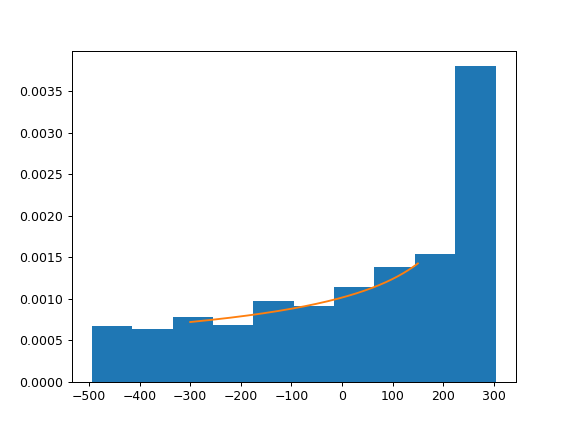

In [56]:
plt.figure()
plt.hist(q_push_forward,density=True)
#plt.plot(np.linspace(-3,3,200),q_obs.pdf(np.linspace(-3,3,200)))
plt.plot(np.linspace(-300,150,200),push_forward_pdf(np.linspace(-300,150,200)))

In [57]:
# compute the updated sample
# calculate maximum of the ratio
M = np.max(q_obs.pdf(q_push_forward)/push_forward_pdf(q_push_forward))

# generate random numbers from uniform for accept-reject for each sample value
test_value = np.random.uniform(0,1,np.shape(q_push_forward))

# calculate the ratio for accept reject: data_kde/push_kde/M and compare to test sample
# is the kde ratio > test value?
accept_or_reject_samples = np.greater(q_obs.pdf(q_push_forward)/push_forward_pdf(q_push_forward)/M,
                            test_value)

# accepted values of posterior sample
lam_update_sample = lam_prior_sample[accept_or_reject_samples]

<IPython.core.display.Javascript object>


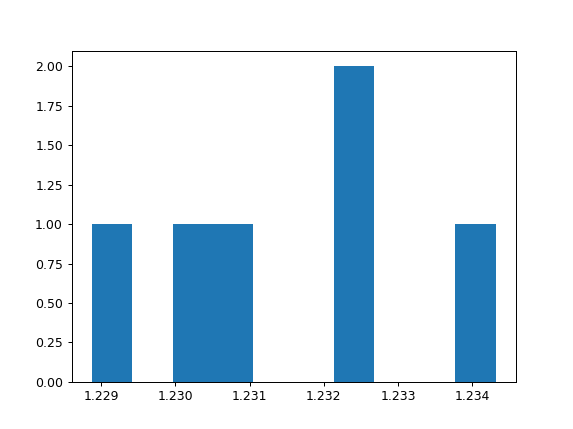

1.23164019328
1.2317488945


In [58]:
plt.figure()
plt.hist(lam_update_sample)
print(np.mean(lam_update_sample))
print(np.median(lam_update_sample))

In [59]:
# exact estimator
def exact_estimate(s,N):
    # lambda estimate squared, numerical value
    lam_approx = np.sqrt((s+np.sqrt(s**2+2*N*noise**2))/2/N)
    return lam_approx

In [60]:
exact_estimate(s,N)

1.2323470907523166

In [61]:
# error analysis
# check errors for 10, 100, 500, 1000, N samples
sample_sizes = np.array([10,100,500,1000,N])

abs_error = np.zeros(len(sample_sizes))

for (i,m) in enumerate(sample_sizes):
    estimate = exact_estimate(np.sum(obs_data[0:m]),m)
    abs_error[i] = abs(estimate - lam_true)
    

In [62]:
M = sample_sizes[3]
print(M)

1000


In [63]:
# check analytic error result for bias
y_prime_0 = 3*lam_true**2 # derivative of Y at lam_0
y_prime_prime_0 = 6*lam_true

# "a" constants
a0 = y_prime_0/noise**2
a1 = y_prime_prime_0/noise**2
a2 = 0

# "b" constants
b1 = (y_prime_0/noise)**2
b2 = 3*(y_prime_0)*(y_prime_prime_0)/(2*noise**2)

# "g" constants
g0 = 1/4*(model_Y(lam_true))**(-1/2)*y_prime_0
g1 = -1/8*(model_Y(lam_true))**(-3/2)*y_prime_0**2+1/4*(model_Y(lam_true))**(-1/2)*y_prime_prime_0


In [64]:
print(b2/b1)

2.439024390243903


<IPython.core.display.Javascript object>


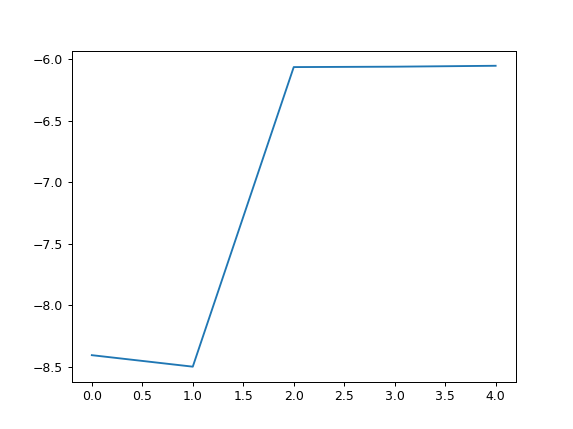

In [65]:
plt.figure()
plt.plot(np.log(abs_error))

In [66]:
def many_estimates(run_times):
    # how many observations per experiment?
    N = 5000
    
    # save estimates
    estimates = np.zeros(run_times)
    
    # generate all the estimates
    for k in np.arange(run_times):
        # generate observations for kth experiment
        observations = model_Y(lam_true)+epsilon.rvs(N)
        
        # compute estimate
        s = np.sum(observations)
        estimates[k] = exact_estimate(s,N)
        
    return estimates

In [67]:
test = many_estimates(300)

<IPython.core.display.Javascript object>


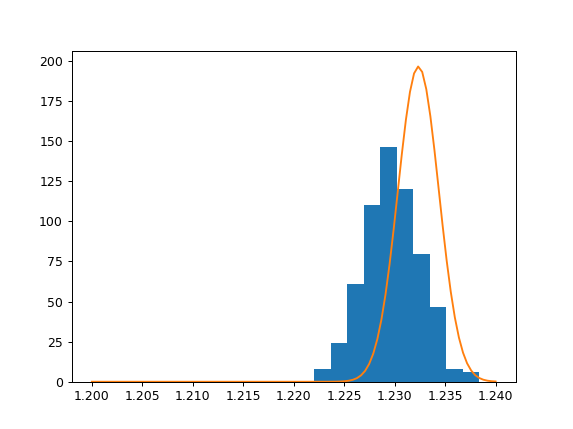

In [68]:
plt.figure()
plt.hist(test, density=True)

x = np.linspace(1.2,1.24,100)
y = lam_prior.pdf(x)*q_obs.pdf(Q(x,obs_data))/push_forward_pdf(Q(x,obs_data))
plt.plot(x,y)

## What does $Q$-Map Look Like w.r.t $\lambda$?

In [69]:
# we have some true value of lambda:
lam_true = 1.23

# we have the model Y:
def model_Y(x):
    return x**2*np.sin(x)

# we have some noise
noise = 0.5 # how noisy?
epsilon = norm(0,noise) # mean 0

# and some observations of the model Y with noise
N = 10000 # number of observations
obs_data = model_Y(lam_true)+epsilon.rvs(N)

# this is the prior
lam_prior = uniform(0,2)

def Q(lam, data, N_data=0):
    if N_data<=0:
        N = len(data)
    else:
        N = N_data
    q = (np.sum(data[1:N])-N*model_Y(lam))/(np.sqrt(N)*noise)  # constant - vector of potential lambdas
    return q

# the observed distribution of the residuals from Q
q_obs = norm(0,1) # variance n*sigma^2

# generate sample of lambda
n = 1500
lam_prior_sample = lam_prior.rvs(n)

# compute push-forward of lambda using the map
q_push_forward = Q(lam_prior_sample,obs_data)

# lambda slice
lam_fix = np.linspace(0,2,350)

# q_fix
q_fix = np.linspace(min(q_push_forward),max(q_push_forward),150)


In [70]:
data_points_slider = widgets.IntSlider(
                        value=1,
                        min=1,
                        max=100,
                        step=1,
                        description='# Points:',
                        disabled=False,
                        continuous_update=False,
                        orientation='horizontal',
                        readout=True,
                        readout_format='d'
)

In [71]:
### FIGURE INFORMATION: same for each sub-example
# NOTE: These are global variables
######### EACH EXAMPLE HAS THIS SAME FORMAT
# defines two plots
plt.ioff() # turns off interactive plot so it doesn't show until ready
# Defines Figure
# defines two plots
q_lambda_plots, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

# Plot densities
current_hist = ax1.hist(q_push_forward,density=True)
ax1.plot(q_fix,q_obs.pdf(q_fix), scaley=False)

# Plot Lambda vs. Q Map
ax2.plot(lam_fix,Q(lam_fix,obs_data),color='C0',alpha=0.55,label='Full Data')
ax2.plot(lam_fix,np.zeros(len(lam_fix)),ls='--',color='k')
ax2.axhspan(-1.96,1.96,color='C1',alpha=0.15,zorder=1)
ax2.plot(lam_true,0,color='r', marker='o',label='$\lambda$-true')
current_data, = ax2.plot(lam_fix,Q(lam_fix,obs_data),color='C0',label='Current Data')
current_data.set_visible(False)

left_line, = ax2.plot([0,0],[ax2.get_ylim()[0],1.96])
right_line, = ax2.plot([0,0],[ax2.get_ylim()[0],1.96])

current_mode, = ax2.plot(0,0, marker='o',color='b')

# other options
ax1.set_ylabel("Density")
ax1.set_xlabel("Q-Space")
ax2.set_xlabel("$\lambda$-Space")
ax2.set_ylabel("Q-Space")
ax2.set_ylim(-5,5)
ax2.legend()

plt.ion() # turns on interactive plot so it will show when display command called later
#########

In [72]:
def new_data_point_slider(change):
    if change.new is not None:
        # change to 
        new_y_values = Q(lam_fix,obs_data,data_points_slider.value)
        current_data.set_ydata(new_y_values)
        
        idx = np.argmin(np.abs(new_y_values))
        current_mode.set_xdata(lam_fix[idx])
        current_mode.set_ydata(new_y_values[idx])
        
        current_data.set_visible(True)
        q_lambda_plots.canvas.draw()


In [73]:
data_points_slider.observe(new_data_point_slider)

<IPython.core.display.Javascript object>


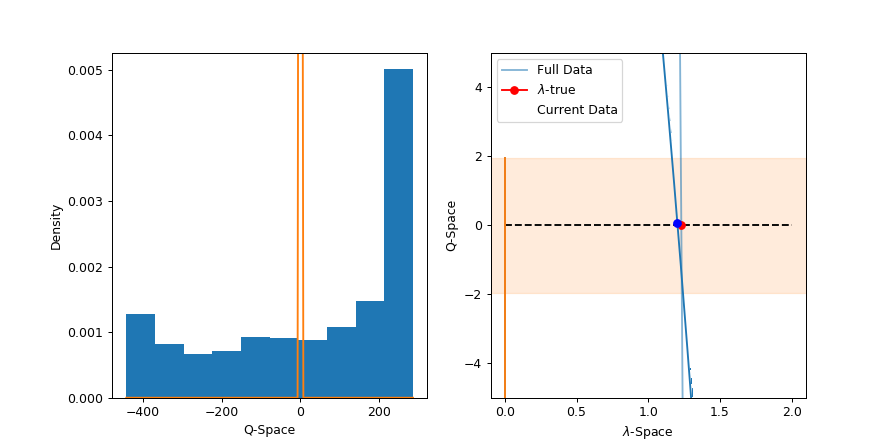

A Jupyter Widget

In [74]:
display(q_lambda_plots)
display(data_points_slider)

In [75]:
ax2.set_ylim(-5,5)

(-5, 5)

In [76]:
q_push_forward

array([  21.36190691, -401.30466451,  263.90169804, ...,  271.76677284,
        187.69132138, -304.76007291])